In [1]:
# 데이터 처리 및 분석
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 출력 설정
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# 한글 폰트 설정
import platform
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)

# 시드 설정
np.random.seed(42) # 팀원간의 결과물이 동일하게 보일 수 있음

print("="*60)
print("라이브러리 로드 완료!")
print("한글 폰트 설정 완료!")
print("="*60)

라이브러리 로드 완료!
한글 폰트 설정 완료!


# 환경관리기 전처리

In [3]:
import pandas as pd

df_environment = pd.read_csv('../../data/raw/환경관리기.csv', encoding='utf-8')

In [ ]:
df_environment.columns

Index(['No', '지역', '규모', '농가명', '장비종류', '제조사아이디', '장비번호', '측정일시',
       '측정값(℃ · % · ppm)'],
      dtype='object')

In [ ]:
df_environment_copy = df_environment.copy()
df_environment_copy.drop(columns=['지역', '제조사아이디', '장비번호'], inplace=True)


In [ ]:
df_environment_copy.columns

Index(['No', '규모', '농가명', '장비종류', '측정일시', '측정값(℃ · % · ppm)'], dtype='object')

In [ ]:
df_environment['측정값(℃ · % · ppm)']

0        76.09
1        62.75
2        49.33
3        37.54
4        58.08
         ...  
28304    30.00
28305    29.00
28306    28.00
28307    28.00
28308    30.00
Name: 측정값(℃ · % · ppm), Length: 28309, dtype: float64

In [ ]:
# 일부러 No, 제조사아이디를 제외하고 만듦
env_pivot = (
    df_environment_copy[['규모', '농가명', '장비종류', '측정일시', '측정값(℃ · % · ppm)']].pivot_table(
        index=['규모', '농가명', '측정일시'],
        columns='장비종류',
        values='측정값(℃ · % · ppm)'
    )
    .reset_index()
)
env_pivot.columns.name = None

In [ ]:
env_pivot

,규모,농가명,측정일시,CO2,습도,온도
0,100~200,20250,20200727,518.0,82.0,26.0
1,100~200,20250,20200728,520.0,82.0,27.0
2,100~200,20250,20200729,524.0,82.0,26.0
3,100~200,20250,20200730,529.0,82.0,28.0
4,100~200,20250,20200731,528.0,82.0,28.0
...,...,...,...,...,...,...
15848,500~1000,20268,20201215,552.0,73.0,1.0
15849,500~1000,20268,20201216,560.0,80.0,0.0
15850,500~1000,20268,20210129,544.0,67.0,-2.0
15851,500~1000,20268,20210321,557.0,81.0,9.0


In [ ]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import numpy as np

env_pivot_copy = env_pivot.copy()

# 1. 습도 컬럼에서 0을 NaN으로 변경
env_pivot_copy['습도'] = env_pivot_copy['습도'].replace(0, np.nan)

# 2. 정규화 대상 컬럼 선택
cols_to_impute = ['습도']  # 예시

# 3. 정규화
scaler = StandardScaler()
scaled = scaler.fit_transform(env_pivot_copy[cols_to_impute])

# 4. KNNImputer 적용
imputer = KNNImputer(n_neighbors=5)
imputed = imputer.fit_transform(scaled)

# 5. 다시 원래 스케일로 되돌리기
restored = scaler.inverse_transform(imputed)

# 6. 보간된 값 반영
env_pivot_copy[cols_to_impute] = restored

env_pivot_copy.isnull().sum()


규모          0
농가명         0
측정일시        0
CO2     13761
습도          0
온도        384
dtype: int64

In [ ]:
env_pivot['측정일시'].dtype

dtype('int64')

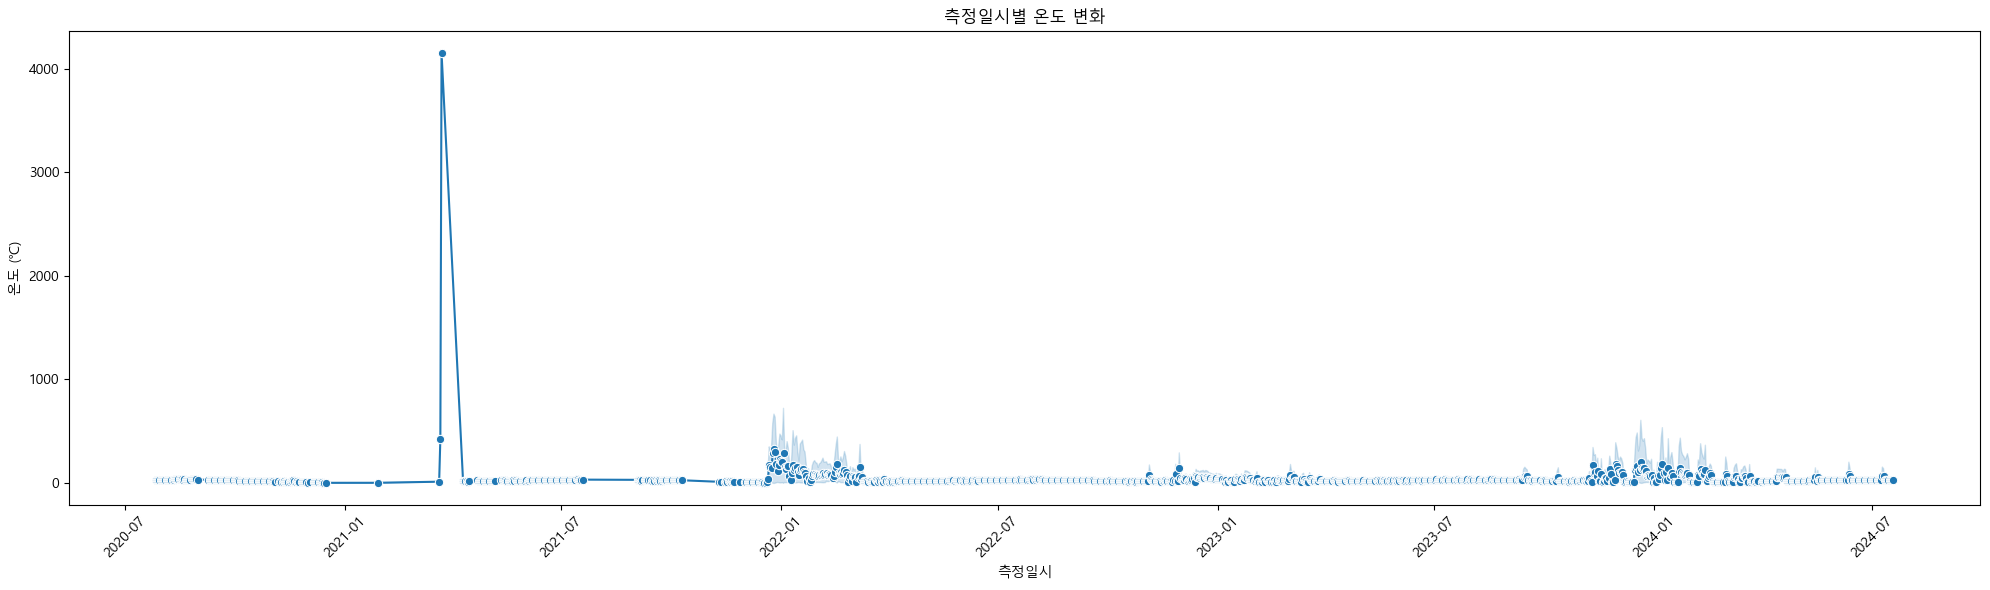

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. '측정 일시'를 datetime 형식으로 변환
import pandas as pd

# 예시: '측정일시' 컬럼이 int 형식일 경우
env_pivot_copy['측정일시'] = pd.to_datetime(env_pivot_copy['측정일시'].astype(str), format='%Y%m%d')


# 2. 시간 순으로 정렬
env_pivot_copy = env_pivot_copy.sort_values('측정일시')

# 3. 선그래프 그리기
plt.figure(figsize=(20, 6))
sns.lineplot(data=env_pivot_copy, x='측정일시', y='온도', marker='o')
plt.title('측정일시별 온도 변화')
plt.xlabel('측정일시')
plt.ylabel('온도 (℃)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import plotly.express as px
# 3. Plotly 선그래프 생성
fig = px.line(
    env_pivot_copy,
    x='측정일시',
    y='온도',
    title='측정일시별 온도 변화',
    markers=True,
    labels={'측정일시': '측정일시', '온도': '온도 (℃)'}
)

# 4. x축 포맷 설정 (년-월만 표시)
fig.update_layout(
    xaxis_title='측정일시',
    yaxis_title='온도 (℃)',
    xaxis_tickangle=45,
    width=2000,
    height=700,
    xaxis=dict(
        tickformat='%Y-%m'  # 년-월 형식
    )
)

fig.show()


**소가 생존할 수 있는 최고 온도는 일반적으로 약 32℃를 넘기면 스트레스를 받기 시작하며, 40℃ 이상에서는 생존에 심각한 영향을 줄 수 있습니다.**

---

## 🐄 소의 고온 스트레스 한계

- **온도-습도지수(THI)** 기준으로 소의 열 스트레스는 다음과 같이 분류됩니다:
  - **THI 72 이상**: 경미한 스트레스 시작
  - **THI 78 이상**: 중간 수준 스트레스
  - **THI 82 이상**: 심각한 스트레스
- 이 지수는 온도와 습도를 함께 고려하며, **섭씨 32℃ 이상**에서 습도가 높을 경우 THI가 급격히 상승합니다.

---

## 🔥 실제 생존 한계

- **40℃ 이상**의 고온 환경에서는 소의 체온 조절 능력이 급격히 저하되어 **호흡 증가, 식욕 감소, 생산량 저하, 심하면 폐사**까지 이어질 수 있어요.
- 특히 **젖소**는 고온에 더 민감하며, **착유량이 10~25%까지 감소**할 수 있습니다.

---

## 🌡️ 관리 팁

- **그늘 제공, 환기, 물 충분히 공급, 안개 분무기 사용** 등으로 열 스트레스를 완화할 수 있어요.
- 고온기에는 **사료 섭취량 감소**로 인해 영양 불균형이 생기기 쉬우므로 **고에너지 사료 보충**이 필요합니다.

---

**Follow-up:** 소의 열 스트레스 지표인 THI를 계산해서 농장 환경 데이터와 비교해볼 수 있어요. 원하시면 바로 계산해드릴게요. 

Sources: 

In [ ]:
import numpy as np

# 온도 값이 40 이상인 경우 NaN으로 변경
env_pivot_copy['온도'] = env_pivot_copy['온도'].mask(env_pivot_copy['온도'] >= 40, np.nan)


In [ ]:

# 3. Plotly 선그래프 생성
fig = px.line(
    env_pivot_copy,
    x='측정일시',
    y='온도',
    title='측정일시별 온도 변화',
    markers=True,
    labels={'측정일시': '측정일시', '온도': '온도 (℃)'}
)

# 4. x축 포맷 설정 (년-월만 표시)
fig.update_layout(
    xaxis_title='측정일시',
    yaxis_title='온도 (℃)',
    xaxis_tickangle=45,
    width=2500,
    height=700,
    xaxis=dict(
        tickformat='%Y-%m',       # 년-월 형식
        ticklabelmode='period',   # 월 단위로 라벨 표시
        dtick='M1'                # 1개월 간격으로 눈금 표시
    )
)


fig.show()

### 농장별로 봐서 이상치 판단

In [ ]:
farm_name = env_pivot_copy['농가명'].unique()

len(env_pivot_copy['농가명'].unique())
env_pivot_copy['농가명'].unique()


array([20250, 20288, 20275, 20278, 20269, 20268, 20265, 20251, 20276,
       20264, 20445, 20381, 21790, 21146, 21134, 21670, 20652, 21678,
       22195, 21793, 21425, 20410, 21135, 22254, 22153, 22222, 21842,
       22062, 22302, 22156, 21906, 21669, 21043, 22491, 22751, 20647,
       22498, 23018, 22771, 22907, 23025, 23024, 22992, 23022, 20285,
       22947, 22922, 22283, 22918, 22975, 21148, 22994, 22166, 22926,
       22970, 21141, 22919, 22902, 21651, 20650, 22942, 23041, 22925,
       22964, 22924, 23021, 22908, 22946, 22938, 20249, 22973, 22930,
       22885, 22754])

{np.int64(20249), np.int64(20250), np.int64(20251), np.int64(20264), np.int64(20265), np.int64(20268), np.int64(20269), np.int64(20276), np.int64(20278), np.int64(21134), np.int64(21135), np.int64(21141), np.int64(21146), np.int64(21148), np.int64(21678), np.int64(21790)}

In [ ]:
import plotly.express as px

# 2. 농가명 20249 데이터만 필터링
farm_df = env_pivot_copy[env_pivot_copy['농가명'] == 20249].sort_values('측정일시')

# 3. Plotly 선그래프 생성
fig = px.line(
    farm_df,
    x='측정일시',
    y='온도',
    title='1. 농가 20249 - 측정일시별 온도 변화',
    markers=True,
    labels={'측정일시': '측정일시', '온도': '온도 (℃)'}
)

# 4. x축 포맷 및 간격 설정 (모든 년-월 표시)
fig.update_layout(
    xaxis=dict(
        tickformat='%Y-%m',     # 년-월 형식
        ticklabelmode='period', # 월 단위 라벨 표시
        dtick='M1',             # 1개월 간격 눈금
    ),
    xaxis_title='측정일시',
    yaxis_title='온도 (℃)',
    xaxis_tickangle=45,
    width=2500,
    height=600
)

fig.show()


In [ ]:
import plotly.express as px

# 2. 농가명 20250 데이터만 필터링
farm_df = env_pivot_copy[env_pivot_copy['농가명'] == 20250].sort_values('측정일시')

# 3. Plotly 선그래프 생성
fig = px.line(
    farm_df,
    x='측정일시',
    y='온도',
    title='2. 농가명 20250 - 측정일시별 온도 변화',
    markers=True,
    labels={'측정일시': '측정일시', '온도': '온도 (℃)'}
)

# 4. x축 포맷 및 간격 설정 (모든 년-월 표시)
fig.update_layout(
    xaxis=dict(
        tickformat='%Y-%m',     # 년-월 형식
        ticklabelmode='period', # 월 단위 라벨 표시
        dtick='M1',             # 1개월 간격 눈금
    ),
    xaxis_title='측정일시',
    yaxis_title='온도 (℃)',
    xaxis_tickangle=45,
    width=2500,
    height=600
)

fig.show()

In [ ]:
import plotly.express as px

# 2. 농가명 20251 데이터만 필터링
farm_df = env_pivot_copy[env_pivot_copy['농가명'] == 20251].sort_values('측정일시')

# 3. Plotly 선그래프 생성
fig = px.line(
    farm_df,
    x='측정일시',
    y='온도',
    title='3. 농가명 20251 - 측정일시별 온도 변화',
    markers=True,
    labels={'측정일시': '측정일시', '온도': '온도 (℃)'}
)

# 4. x축 포맷 및 간격 설정 (모든 년-월 표시)
fig.update_layout(
    xaxis=dict(
        tickformat='%Y-%m',     # 년-월 형식
        ticklabelmode='period', # 월 단위 라벨 표시
        dtick='M1',             # 1개월 간격 눈금
    ),
    xaxis_title='측정일시',
    yaxis_title='온도 (℃)',
    xaxis_tickangle=45,
    width=2500,
    height=600
)

fig.show()

In [ ]:
# 농가명이 20251이 아닌 행만 남기기
env_pivot_copy = env_pivot_copy[env_pivot_copy['농가명'] != 20251]


In [ ]:
import plotly.express as px

# 2. 농가명 20264 데이터만 필터링
farm_df = env_pivot_copy[env_pivot_copy['농가명'] == 20264].sort_values('측정일시')

# 3. Plotly 선그래프 생성
fig = px.line(
    farm_df,
    x='측정일시',
    y='온도',
    title='4. 농가명 20264 - 측정일시별 온도 변화',
    markers=True,
    labels={'측정일시': '측정일시', '온도': '온도 (℃)'}
)

# 4. x축 포맷 및 간격 설정 (모든 년-월 표시)
fig.update_layout(
    xaxis=dict(
        tickformat='%Y-%m',     # 년-월 형식
        ticklabelmode='period', # 월 단위 라벨 표시
        dtick='M1',             # 1개월 간격 눈금
    ),
    xaxis_title='측정일시',
    yaxis_title='온도 (℃)',
    xaxis_tickangle=45,
    width=2500,
    height=600
)

fig.show()

In [ ]:
import plotly.express as px

# 2. 농가명 20265 데이터만 필터링
farm_df = env_pivot_copy[env_pivot_copy['농가명'] == 20265].sort_values('측정일시')

# 3. Plotly 선그래프 생성
fig = px.line(
    farm_df,
    x='측정일시',
    y='온도',
    title='농가명 20265 - 측정일시별 온도 변화',
    markers=True,
    labels={'측정일시': '측정일시', '온도': '온도 (℃)'}
)

# 4. x축 포맷 및 간격 설정 (모든 년-월 표시)
fig.update_layout(
    xaxis=dict(
        tickformat='%Y-%m',     # 년-월 형식
        ticklabelmode='period', # 월 단위 라벨 표시
        dtick='M1',             # 1개월 간격 눈금
    ),
    xaxis_title='측정일시',
    yaxis_title='온도 (℃)',
    xaxis_tickangle=45,
    width=2500,
    height=600
)

fig.show()

In [ ]:
import plotly.express as px

# 2. 농가명 20268 데이터만 필터링
farm_df = env_pivot_copy[env_pivot_copy['농가명'] == 20268].sort_values('측정일시')

# 3. Plotly 선그래프 생성
fig = px.line(
    farm_df,
    x='측정일시',
    y='온도',
    title='농가명 20268 - 측정일시별 온도 변화',
    markers=True,
    labels={'측정일시': '측정일시', '온도': '온도 (℃)'}
)

# 4. x축 포맷 및 간격 설정 (모든 년-월 표시)
fig.update_layout(
    xaxis=dict(
        tickformat='%Y-%m',     # 년-월 형식
        ticklabelmode='period', # 월 단위 라벨 표시
        dtick='M1',             # 1개월 간격 눈금
    ),
    xaxis_title='측정일시',
    yaxis_title='온도 (℃)',
    xaxis_tickangle=45,
    width=2500,
    height=600
)

fig.show()

In [ ]:
# 2. 농가명 20269 데이터만 필터링
farm_df = env_pivot_copy[env_pivot_copy['농가명'] == 20269].sort_values('측정일시')

# 3. Plotly 선그래프 생성
fig = px.line(
    farm_df,
    x='측정일시',
    y='온도',
    title='농가명 20269 - 측정일시별 온도 변화',
    markers=True,
    labels={'측정일시': '측정일시', '온도': '온도 (℃)'}
)

# 4. x축 포맷 및 간격 설정 (모든 년-월 표시)
fig.update_layout(
    xaxis=dict(
        tickformat='%Y-%m',     # 년-월 형식
        ticklabelmode='period', # 월 단위 라벨 표시
        dtick='M1',             # 1개월 간격 눈금
    ),
    xaxis_title='측정일시',
    yaxis_title='온도 (℃)',
    xaxis_tickangle=45,
    width=2500,
    height=600
)

fig.show()

In [ ]:
# 2. 농가명 20276 데이터만 필터링
farm_df = env_pivot_copy[env_pivot_copy['농가명'] == 20276].sort_values('측정일시')

# 3. Plotly 선그래프 생성
fig = px.line(
    farm_df,
    x='측정일시',
    y='온도',
    title='농가명 20276 - 측정일시별 온도 변화',
    markers=True,
    labels={'측정일시': '측정일시', '온도': '온도 (℃)'}
)

# 4. x축 포맷 및 간격 설정 (모든 년-월 표시)
fig.update_layout(
    xaxis=dict(
        tickformat='%Y-%m',     # 년-월 형식
        ticklabelmode='period', # 월 단위 라벨 표시
        dtick='M1',             # 1개월 간격 눈금
    ),
    xaxis_title='측정일시',
    yaxis_title='온도 (℃)',
    xaxis_tickangle=45,
    width=2500,
    height=600
)

fig.show()

In [ ]:
# 2. 농가명 20278 데이터만 필터링
farm_df = env_pivot_copy[env_pivot_copy['농가명'] == 20278].sort_values('측정일시')

# 3. Plotly 선그래프 생성
fig = px.line(
    farm_df,
    x='측정일시',
    y='온도',
    title='농가명 20278 - 측정일시별 온도 변화',
    markers=True,
    labels={'측정일시': '측정일시', '온도': '온도 (℃)'}
)

# 4. x축 포맷 및 간격 설정 (모든 년-월 표시)
fig.update_layout(
    xaxis=dict(
        tickformat='%Y-%m',     # 년-월 형식
        ticklabelmode='period', # 월 단위 라벨 표시
        dtick='M1',             # 1개월 간격 눈금
    ),
    xaxis_title='측정일시',
    yaxis_title='온도 (℃)',
    xaxis_tickangle=45,
    width=2500,
    height=600
)

fig.show()

In [ ]:
# 2. 농가명 21134 데이터만 필터링
farm_df = env_pivot_copy[env_pivot_copy['농가명'] == 21134].sort_values('측정일시')

# 3. Plotly 선그래프 생성
fig = px.line(
    farm_df,
    x='측정일시',
    y='온도',
    title='농가명 21134 - 측정일시별 온도 변화',
    markers=True,
    labels={'측정일시': '측정일시', '온도': '온도 (℃)'}
)

# 4. x축 포맷 및 간격 설정 (모든 년-월 표시)
fig.update_layout(
    xaxis=dict(
        tickformat='%Y-%m',     # 년-월 형식
        ticklabelmode='period', # 월 단위 라벨 표시
        dtick='M1',             # 1개월 간격 눈금
    ),
    xaxis_title='측정일시',
    yaxis_title='온도 (℃)',
    xaxis_tickangle=45,
    width=2500,
    height=600
)

fig.show()

In [ ]:
# 2. 농가명 21135 데이터만 필터링
farm_df = env_pivot_copy[env_pivot_copy['농가명'] == 21135].sort_values('측정일시')

# 3. Plotly 선그래프 생성
fig = px.line(
    farm_df,
    x='측정일시',
    y='온도',
    title='농가명 21135 - 측정일시별 온도 변화',
    markers=True,
    labels={'측정일시': '측정일시', '온도': '온도 (℃)'}
)

# 4. x축 포맷 및 간격 설정 (모든 년-월 표시)
fig.update_layout(
    xaxis=dict(
        tickformat='%Y-%m',     # 년-월 형식
        ticklabelmode='period', # 월 단위 라벨 표시
        dtick='M1',             # 1개월 간격 눈금
    ),
    xaxis_title='측정일시',
    yaxis_title='온도 (℃)',
    xaxis_tickangle=45,
    width=2500,
    height=600
)

fig.show()

In [ ]:
# 2. 농가명 21141 데이터만 필터링
farm_df = env_pivot_copy[env_pivot_copy['농가명'] == 21141].sort_values('측정일시')

# 3. Plotly 선그래프 생성
fig = px.line(
    farm_df,
    x='측정일시',
    y='온도',
    title='농가명 21141 - 측정일시별 온도 변화',
    markers=True,
    labels={'측정일시': '측정일시', '온도': '온도 (℃)'}
)

# 4. x축 포맷 및 간격 설정 (모든 년-월 표시)
fig.update_layout(
    xaxis=dict(
        tickformat='%Y-%m',     # 년-월 형식
        ticklabelmode='period', # 월 단위 라벨 표시
        dtick='M1',             # 1개월 간격 눈금
    ),
    xaxis_title='측정일시',
    yaxis_title='온도 (℃)',
    xaxis_tickangle=45,
    width=2500,
    height=600
)

fig.show()

In [ ]:
# 2. 농가명 21146 데이터만 필터링
farm_df = env_pivot_copy[env_pivot_copy['농가명'] == 21146].sort_values('측정일시')

# 3. Plotly 선그래프 생성
fig = px.line(
    farm_df,
    x='측정일시',
    y='온도',
    title='농가명 21146 - 측정일시별 온도 변화',
    markers=True,
    labels={'측정일시': '측정일시', '온도': '온도 (℃)'}
)

# 4. x축 포맷 및 간격 설정 (모든 년-월 표시)
fig.update_layout(
    xaxis=dict(
        tickformat='%Y-%m',     # 년-월 형식
        ticklabelmode='period', # 월 단위 라벨 표시
        dtick='M1',             # 1개월 간격 눈금
    ),
    xaxis_title='측정일시',
    yaxis_title='온도 (℃)',
    xaxis_tickangle=45,
    width=2500,
    height=600
)

fig.show()

In [ ]:
print(env_pivot_copy['측정일시'].dtype)


datetime64[ns]


In [ ]:
# 조건: 농가명=21146, 2022년 2월, 온도 >= 30
mask = (
    (env_pivot_copy['농가명'] == 21146) &
    (env_pivot_copy['측정일시'].dt.year == 2022) &
    (env_pivot_copy['측정일시'].dt.month == 2) &
    (env_pivot_copy['온도'] >= 30)
)

# 해당 조건을 만족하는 행의 온도를 NaN으로 변경
env_pivot_copy.loc[mask, '온도'] = np.nan

In [ ]:
# 2. 농가명 21146 데이터만 필터링
farm_df = env_pivot_copy[env_pivot_copy['농가명'] == 21146].sort_values('측정일시')

# 3. Plotly 선그래프 생성
fig = px.line(
    farm_df,
    x='측정일시',
    y='온도',
    title='농가명 21146 - 측정일시별 온도 변화',
    markers=True,
    labels={'측정일시': '측정일시', '온도': '온도 (℃)'}
)

# 4. x축 포맷 및 간격 설정 (모든 년-월 표시)
fig.update_layout(
    xaxis=dict(
        tickformat='%Y-%m',     # 년-월 형식
        ticklabelmode='period', # 월 단위 라벨 표시
        dtick='M1',             # 1개월 간격 눈금
    ),
    xaxis_title='측정일시',
    yaxis_title='온도 (℃)',
    xaxis_tickangle=45,
    width=2500,
    height=600
)

fig.show()

In [ ]:
# 2. 농가명 21148 데이터만 필터링
farm_df = env_pivot_copy[env_pivot_copy['농가명'] == 21148].sort_values('측정일시')

# 3. Plotly 선그래프 생성
fig = px.line(
    farm_df,
    x='측정일시',
    y='온도',
    title='농가명 21148 - 측정일시별 온도 변화',
    markers=True,
    labels={'측정일시': '측정일시', '온도': '온도 (℃)'}
)

# 4. x축 포맷 및 간격 설정 (모든 년-월 표시)
fig.update_layout(
    xaxis=dict(
        tickformat='%Y-%m',     # 년-월 형식
        ticklabelmode='period', # 월 단위 라벨 표시
        dtick='M1',             # 1개월 간격 눈금
    ),
    xaxis_title='측정일시',
    yaxis_title='온도 (℃)',
    xaxis_tickangle=45,
    width=2500,
    height=600
)

fig.show()

In [ ]:
# 2. 농가명 21678 데이터만 필터링
farm_df = env_pivot_copy[env_pivot_copy['농가명'] == 21678].sort_values('측정일시')

# 3. Plotly 선그래프 생성
fig = px.line(
    farm_df,
    x='측정일시',
    y='온도',
    title='농가명 21678 - 측정일시별 온도 변화',
    markers=True,
    labels={'측정일시': '측정일시', '온도': '온도 (℃)'}
)

# 4. x축 포맷 및 간격 설정 (모든 년-월 표시)
fig.update_layout(
    xaxis=dict(
        tickformat='%Y-%m',     # 년-월 형식
        ticklabelmode='period', # 월 단위 라벨 표시
        dtick='M1',             # 1개월 간격 눈금
    ),
    xaxis_title='측정일시',
    yaxis_title='온도 (℃)',
    xaxis_tickangle=45,
    width=2500,
    height=600
)

fig.show()

In [ ]:
# 조건: 농가명=21678, 2022년 2월, 온도 >= 30
mask = (
    (env_pivot_copy['농가명'] == 21678) &
    (env_pivot_copy['측정일시'].dt.year == 2022) &
    (env_pivot_copy['측정일시'].dt.month == 2) &
    (env_pivot_copy['온도'] >= 30)
)

# 해당 조건을 만족하는 행의 온도를 NaN으로 변경
env_pivot_copy.loc[mask, '온도'] = np.nan

In [ ]:
# 2. 농가명 21790 데이터만 필터링
farm_df = env_pivot_copy[env_pivot_copy['농가명'] == 21790].sort_values('측정일시')

# 3. Plotly 선그래프 생성
fig = px.line(
    farm_df,
    x='측정일시',
    y='온도',
    title='농가명 21790 - 측정일시별 온도 변화',
    markers=True,
    labels={'측정일시': '측정일시', '온도': '온도 (℃)'}
)

# 4. x축 포맷 및 간격 설정 (모든 년-월 표시)
fig.update_layout(
    xaxis=dict(
        tickformat='%Y-%m',     # 년-월 형식
        ticklabelmode='period', # 월 단위 라벨 표시
        dtick='M1',             # 1개월 간격 눈금
    ),
    xaxis_title='측정일시',
    yaxis_title='온도 (℃)',
    xaxis_tickangle=45,
    width=2500,
    height=600
)

fig.show()

In [ ]:
# 1️⃣ 농가명 21790 & 2022년 2월 & 온도 >= 30 → NaN
mask1 = (
    (env_pivot_copy['농가명'] == 21790) &
    (env_pivot_copy['측정일시'].dt.year == 2022) &
    (env_pivot_copy['측정일시'].dt.month == 2) &
    (env_pivot_copy['온도'] >= 30)
)
env_pivot_copy.loc[mask1, '온도'] = np.nan

# 2️⃣ 농가명 21790 & 2023년 7월 이후 & (온도 == 33 or 온도 == 0) → NaN
mask2 = (
    (env_pivot_copy['농가명'] == 21790) &
    (env_pivot_copy['측정일시'] >= pd.to_datetime("2023-07-01")) &
    ((env_pivot_copy['온도'] == 33) | (env_pivot_copy['온도'] == 0))
)
env_pivot_copy.loc[mask2, '온도'] = np.nan

In [ ]:
# 2. 농가명 21790 데이터만 필터링
farm_df = env_pivot_copy[env_pivot_copy['농가명'] == 21790].sort_values('측정일시')

# 3. Plotly 선그래프 생성
fig = px.line(
    farm_df,
    x='측정일시',
    y='온도',
    title='농가명 21790 - 측정일시별 온도 변화',
    markers=True,
    labels={'측정일시': '측정일시', '온도': '온도 (℃)'}
)

# 4. x축 포맷 및 간격 설정 (모든 년-월 표시)
fig.update_layout(
    xaxis=dict(
        tickformat='%Y-%m',     # 년-월 형식
        ticklabelmode='period', # 월 단위 라벨 표시
        dtick='M1',             # 1개월 간격 눈금
    ),
    xaxis_title='측정일시',
    yaxis_title='온도 (℃)',
    xaxis_tickangle=45,
    width=2500,
    height=600
)

fig.show()

In [ ]:
# env_pivot_copy를 CSV 파일로 저장
env_pivot_copy.to_csv("../../data/interim/env_pivot_clean.csv", index=False, encoding="utf-8-sig")


# 유성분검사성적서 전처리

In [ ]:
report = pd.read_csv('../../data/raw/유성분검사성적서.csv')
df = report.copy()

In [ ]:
# 불필요 컬럼 drop
drop_col = [
   '혈통번호', '착유일련번호', '체점수(연계)', '유성분검사일련번호', '단백율', '고형율', '유당', '검정일시(ICT)',
'분만나이(연계)', '가수제코드(연계)', '가수제일자(연계)', '분만후첫수정일까지일수', '데이터입력코드', '최근분만일(연계)',
'최종수정일자(연계)', '최종수정횟수(연계)', '최종수정정액코드(연계)', '최근건유일(연계)', '개체명', '농장관리번호'
]

df.drop(columns=drop_col, inplace=True, errors='ignore')


In [ ]:
# 불필요 행 drop
drop_row = [
    '개체번호', '비유최고도달일수', '비유후기최고유량',
    '비유초기평균유지율', '비유초기평균단백율', '비유초기평균MNU', '전산차비유지속성'
]

df.dropna(subset=drop_row, inplace=True)

In [ ]:
# 305일 관련 행 nan값으로 채우기

nan_305 = ['305일유량', '305일유지량', '305일유단백', '305일무지고형분']

df[nan_305] = df[nan_305].replace(0, np.nan)


In [ ]:
# '비유초기평균MNU' -> '비유초기평균MUN'
df.rename(columns={'비유초기평균MNU': '비유초기평균MUN'}, inplace=True)

In [ ]:
# 날짜 기준 정렬
df['검정일자'] = pd.to_datetime(df['검정일자'])
df = df.sort_values(['개체번호', '검정일자'])

# 개체별 전월 유량 가져오기
df['전월유량'] = df.groupby('개체번호')['유량'].shift(1)

# 유량 변화율 계산: ((현재 - 전월) / 전월) * 100
df['유량변화율(%)'] = (df['유량'] - df['전월유량']) / df['전월유량'] * 100

# 질병군 생성: 체세포수 ≥200 & 전월 대비 유량 10% 이상 감소 → 1(의심군), 나머지 0(정상군)
df['질병군'] = np.where((df['체세포수'] >= 200) & (df['유량변화율(%)'] <= -10), 1, 0)

# 중간 계산용 컬럼 제거
df.drop(columns=['전월유량', '유량변화율(%)'], inplace=True)


In [ ]:
# df를 CSV 파일로 저장
df.to_csv("../../data/interim/milk.csv", index=False, encoding="utf-8-sig")
